## P4DS (ODL1) Assignment 3

# Data Analysis Project

#### Notebook template design: Brandon Bennett (2020.11.03, revised 2021.03.02)

# Sentiment analysis applied to the Videogame Industry: The audience reaction to Mario+Rabbids: Sparks of Hope's Ubisoft announcement


#### Student: Gianmarco Picarella

#### Email: od21gp@leeds.ac.uk

# Project Plan

## The Data (10 marks)

### Where the data comes from
_For the purposes of this project, we need a data source that represents the overall audience interested in a particular videogame.<br>_
_There are multiple online platforms at our disposal: Twitch, Reddit, and YouTube are the top choices when asking for information related to the videogame industry.<br>_
_Among all, YouTube has by far the most diversified and reliable videogames audience data available online.<br>_
_Another advantage is that almost every video game announcement trailer is published on Youtube, making it a gathering and reference point for gamers.<br>_

### How the data is organized
_The data used to carry out the analyses is composed of a series of CSV formatted text files containing a list of comments referred to a specific youtube video.<br>
For our purposes, we have two different CSV files, one for each announcement trailer.<br>
Each row in the file has five columns: the **row index**, **author name**, **comment text**, **like counter**, and the **publication date and time**.<br>
Each entry represents the previously mentioned columns using an **integer**, **string**, **string**, **integer**, and **UTC formatted string**.<br>_

### How the data is collected
_The data is retrieved using **Google's YouTube API wrapper**, available through a specific python package.<br>
Starting from the JSON obtained through the API, we copy only the fields mentioned above in two Pandas Dataframes **DATA_SOH** and **DATA_RKB**, where **SOH** and **RKB** stand for **Sparks of Hope** and **Rabbids Kingdom Battle**.<br>
**DATA_SOH** and **DATA_RKB** contains 9592 and 3707 comments, respectively.<br>_

### Additional supporting data
_In addition to the mentioned data, the project uses other two datasets that are necessary during the transformation phase.<br>
The first dataset -called **ENG_BAG_OF_WORDS** in code- contains the most frequently used English words online.<br>
The dataset is available on [GitHub](https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt) and comprises 466k words from the [WordNet](https://wordnet.princeton.edu/)\[2\] Corpus.<br>
The best result has been achieved by considering only the first 80.000 entries.<br>
The second dataset is a machine learning model that **FastText**\[2\] uses to recognise languages._


## Project Aim and Objectives (5 marks)

_My data analysis project aims to understand how the youtube audience reacted and perceived **Mario+Rabbids: Sparks of Hope**, the Ubisoft videogame sequel announced during the **Ubisoft Forward E3 2021 event**.<br>
Being the sequel of the highly acclaimed **Mario+Rabbids: Kingdom Battle**, the project compares the results of the new Ubisoft's videogame with its predecessor, revealed in 2017, to depict the critical differences between the two announcements in terms of appreciation and virality by the public._

_I will consider the worldwide announcement trailers published by **Nintendo** as data sources to scrape valuable information for our specific purposes._

_The project is based on a series of analyses, each focusing on answering a specific question by exploiting a subset of appropriate data starting from the set of features extrapolated from the over mentioned videos.<br>
The first objective is to determine the overall game appreciation among youtube comments through a Sentiment Analysis algorithm.<br>
As a second interesting goal, I will analyse the sentiment distribution within the first 24 hours from the announcement trailer publication.<br>
In conclusion, I will apply the over mentioned analyses to Mario+Rabbids: Kingdom Battle's announcement trailer and compare the results with those obtained for M+R: Sparks of Hope._

### Specific Objective(s)


* __Objective 1:__ _Analyse the overall sentiment distribution of Mario+Rabbids: Sparks of Hope's announcement trailer._
* __Objective 2:__ _Analyse the sentiment distribution within the first 24 hours from the announcement of Mario+Rabbids: Sparks of Hope._
* __Objective 3:__ _Compare the results with the analysis of Mario+Rabbids: Kingdom Battle's announcement trailer._

## System Design (5 marks)

### Architecture

_The project comprises four macro stages: data retrieval, transformation, analysis, and visualization._

_The data retrieval phase is responsible for retrieving youtube comments from a particular video.<br>
The transformation phase carries out a classification procedure to classify comments as English or not.<br>
After that, a filtering procedure is used to remove any non-English comment from the pandas data frame.<br>
The analysis phase conducts a sentiment and frequency analysis on the transformed data frame._

_At any given stage, there are multiple functions, each of them solving a specific problem.<br>
A final python function will then represent the actual stage using all the previously implemented functions as building blocks.<br>
In my opinion, this structure fits best the idea behind notebooks and prevents long code cells that would have been otherwise necessary using Python classes._

  
### Processing Modules and Algorithms

* #### Retrieve the comments list and build a new pandas dataframe
_We achieve this by abstracting one of the available youtube API wrappers for Python so that from a video id, the function returns a Pandas Dataframe representing the comments list._

* #### Identify and filter out non-English comments
_Each comment is classified by querying the FastText\[2\] library to retrieve its language.<br>
As **FastText**\[2\] uses a probabilistic algorithm based on machine learning, it is still possible for false-positive to occur.<br>
For this reason, we also derive and consider the bag of English words.<br>
If the number of letters belonging to the bag of words is at least 80% of the total text length, then the string is marked as English.<br>
Based on the previous results, each non-English comment is removed._

* #### Identify and filter out comments published out of a given timeframe
_Each comment has a UTC string representing the publication date and time.<br>
We will apply a pandas filtering routine to select only those comment published within a specific time frame._

* #### Apply a Sentiment Analysis algorithm on the filtered dataframe
_We carry out a Sentiment analysis using the **VaderSentiment**\[3\] Python library.<br>
The library is capable of assigning a normalised sentiment score to a given text. It does that by using advanced text parsers and machine learning pre-trained models.<br>
The resulting overall score will be a dictionary containing the number of positive, neutral and negative comments.<br>
We will also consider another scoring method that considers for each comment the number of likes it received._

# Program Code (15 marks)

## Section 1: Retrieve the comments list and build a new pandas DataFrame
### _Importing libraries_

_As a first step, the following cell imports all the necessary libraries used throughout the project._

In [1]:
# pip install vaderSentiment google-api-client fasttext wordcloud

import googleapiclient.discovery
import os
import pandas
import fasttext
import re
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud
import requests
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### _Retrieving Video IDs._

_When querying the YouTube API for specific video information, we must provide the string ID that uniquely identifies the YouTube video.<br>
In this case, we are interested in the IDs for [Mario+Rabbids: Kingdom Battle](https://www.youtube.com/watch?v=DqH-iwA0ZmU) and [Mario+Rabbids: Sparks of Hope](https://www.youtube.com/watch?v=VHIuHMv3t88) YouTube videos.<br>
Retrieving the ID from a URL is straightforward: it is identified by the substring starting right after "v=" -In case of multiple URL arguments, the ID string ends right before the first "?"._

<img src="https://raw.githubusercontent.com/gianmarcopicarella/programming-for-data-science-project-datasets/main/RKB_LINK.png" alt="Video ID location" width="800"/>

_The following cell defines both IDs using two Python global variables._

In [2]:
RKB_VIDEO_ID = "DqH-iwA0ZmU"
SOH_VIDEO_ID = "VHIuHMv3t88"

### _Accessing the YouTube API Gateway_

_Almost every Google Online Service can be queried using different libraries and programming languages.<br>
The GoogleApiClient library is the Pythonic way to query Google Services.<br>
As with every online service, Google requires an **API Key** for each service used.<br>
Fortunately, Google allows the creation of free API Keys as long as the amount of data required monthly stays under a defined limitation.<br>
Again, creating a new API Key is straightforward: it is sufficient to log in to the Google Cloud Platform and go to the [the credential page](https://console.cloud.google.com/apis/credentials)._

<img src="https://raw.githubusercontent.com/gianmarcopicarella/programming-for-data-science-project-datasets/main/API_KEY_1.png" alt="" width="500"/>

_Then click on "Create new credentials"_

<img src="https://raw.githubusercontent.com/gianmarcopicarella/programming-for-data-science-project-datasets/main/API_KEY_2.png" alt="" width="500"/>

_And finally "Create API Key".<br>
In the next cell, I defined a dictionary containing all the initialization data -Including my API Key- needed by the GoogleApiClient library to work correctly._

In [3]:
API_SETTINGS = {"API_KEY": "YOUR_API_KEY",
               "API_VERSION": "v3",
               "API_SERVICE_NAME": "youtube"}

### _Initialise the GoogleApiClient's API Gateway Object_

_Having all the necessary data, the next cell initialises the YouTube API object used to query the YouTube online services._

In [4]:
YOUTUBE_API = googleapiclient.discovery.build(API_SETTINGS["API_SERVICE_NAME"],
                                              API_SETTINGS["API_VERSION"],
                                              developerKey=API_SETTINGS["API_KEY"])

### _Starting making queries to the YouTube API_

_We can now start making queries to the YouTube API. Unfortunately, one of the limitations imposed by the free API Key is that each response can return a maximum of 500 entries.<br> 
This limitation slows down the process when parsing a video with thousands of comments._

_In the next cell, we define a function called json_comments_by_video_id that, starting from a video ID and page token, returns the JSON object representing the list of comments.<br> 
A page token is a bookmark used by the Youtube API, indicating the following comment's page to request. By default, providing an empty page token returns the starting page of comments._

_In addition, an interesting note is that using the "snippet" settings returns only the comments which are not answers to other comments.<br>
This consideration is crucial if we consider the case in which a negative comment receives disapproval with other negative comments.<br>
To simplify the process, I decided to avoid these comments that represent a relatively small subset in most cases._

In [5]:
def json_comments_by_video_id(video_id, page_token="", max_results=500):
    return YOUTUBE_API.commentThreads().list(videoId=video_id,
                                             part='snippet',
                                             pageToken=page_token,
                                             textFormat="plainText", 
                                             maxResults=max_results).execute()

_Let's query the youtube API and see the first 2 result._

In [6]:
json_comments_by_video_id(RKB_VIDEO_ID, "", 2)

{'kind': 'youtube#commentThreadListResponse',
 'etag': '2MJLgK2SZybSU-tUQVIzCoOuy9A',
 'nextPageToken': 'QURTSl9pM3dZc2p2a3N4T21tQ2lmaXhiWDcxQnptdmUzeWlNc3pVMHlZTG1zNUotV1pUaUV0cXBCdVB0bHdOTmdrdFBnZHhXUGE4MFNOUQ==',
 'pageInfo': {'totalResults': 2, 'resultsPerPage': 2},
 'items': [{'kind': 'youtube#commentThread',
   'etag': 'Kj7IzDXWIXF2bhK_1lhCvdgUSgE',
   'id': 'UgzgEqVVwlkyi-IEtW14AaABAg',
   'snippet': {'videoId': 'DqH-iwA0ZmU',
    'topLevelComment': {'kind': 'youtube#comment',
     'etag': '-5IMbnjt9pVxhPEgcCXF7mywMYg',
     'id': 'UgzgEqVVwlkyi-IEtW14AaABAg',
     'snippet': {'videoId': 'DqH-iwA0ZmU',
      'textDisplay': '😲🎮  Nintendo eu tiamo 😍🎮🕹 meu Deus da coração pufavo Nintendo 🇧🇷 eu só muito seu fã gemer super mario Bros e agora e super mario Odysseus 😘😃😄🎮🕹',
      'textOriginal': '😲🎮  Nintendo eu tiamo 😍🎮🕹 meu Deus da coração pufavo Nintendo 🇧🇷 eu só muito seu fã gemer super mario Bros e agora e super mario Odysseus 😘😃😄🎮🕹',
      'authorDisplayName': 'Santhiago Oliveira

_As we can see, the result is represented as a JSON document.<br>
To exploit all the Pandas functionalities, In the next cell, I defined a function called **json_comments_to_list** that, given a JSON partial result, returns the list of dictionaries with the subset of information needed for the analysis._

_For each entry, the function checks if the keys exist and then access them. This check is mandatory to avoid runtime errors when some entries don't have a specific field available._

In [7]:
def json_comments_to_list(json):
    comments = []
    for row in json["items"]:
        if "topLevelComment" in row["snippet"] \
                and "snippet" in row["snippet"]["topLevelComment"]:

                comment = row["snippet"]["topLevelComment"]["snippet"]
                comment_info = {"author": comment["authorDisplayName"],
                               "text": comment["textDisplay"],
                               "likes": comment["likeCount"],
                               "date": comment["updatedAt"]
                               }
                comments.append(comment_info)       
    return comments

_The last function defined in this section uses the above-defined functions and is called **get_video_comments_dataframe**. From a given video ID, the function returns a Pandas DataFrame containing all the comments for that particular video._

In [8]:
def get_video_comments_dataframe(video_id):
    comments, ask_for_new, next_page_token = [], True, ""
    
    while ask_for_new:
        response = json_comments_by_video_id(video_id, next_page_token)
        comments += json_comments_to_list(response)
        ask_for_new = "nextPageToken" in response
        next_page_token = response["nextPageToken"] if ask_for_new else ""
    
    return pandas.DataFrame.from_dict(comments)
    

_Finally, let's use the video IDs to populate the DataFrames with the comments and display them._

In [9]:
# ETA: Less than one minutes

RKB_DT = get_video_comments_dataframe(RKB_VIDEO_ID)

RKB_DT

,author,text,likes,date
0,Santhiago Oliveira,😲🎮 Nintendo eu tiamo 😍🎮🕹 meu Deus da coração ...,0,2021-10-23T01:50:50Z
1,Roopnarine Deonarine,Person at Nintendo: let's make Mario use a gun...,1,2021-10-17T17:05:04Z
2,viktowire,Truly one of the best games I've ever played.,1,2021-09-27T17:23:22Z
3,Tamara Bermudez Diaz,uymjhgyyuuooooolllopt Lu,0,2021-09-25T17:16:43Z
4,Dilmi AOUKLI,even after 4 years............ how?,3,2021-09-22T08:16:05Z
...,...,...,...,...
2953,Eiiro L'Toxico,where is smash,0,2017-06-13T21:30:31Z
2954,Darío García-Franco Gómez de Villavedón,omg,0,2017-06-13T21:30:27Z
2955,Chalish Fadhilah Amin,why?,2,2017-06-13T21:30:18Z
2956,Liam Arra,No,1,2017-06-13T21:30:17Z


In [10]:
# ETA: Less than two minutes

SOH_DT = get_video_comments_dataframe(SOH_VIDEO_ID)

SOH_DT

,author,text,likes,date
0,Polsity,I really we get more than 4 worlds like last ...,0,2021-10-24T15:01:18Z
1,Dakarai Green,The rabbids should be in alot of mario spinoff...,0,2021-10-22T18:55:11Z
2,Koteswara Rao Samsani,Y mmmmhl,0,2021-10-21T23:47:25Z
3,Helem Barrios,Hola Mis Amigos Me Gusta Todas las Estrellas q...,0,2021-10-21T19:10:12Z
4,Juamarques Van den Berg,SMG is my friend Mario game of all time. I hop...,0,2021-10-20T16:42:05Z
...,...,...,...,...
7664,Ricardo Purnell,Polopel,0,2021-06-12T20:14:50Z
7665,Kalicosu,Bruh,0,2021-06-12T20:13:22Z
7666,IkerSito,First,1,2021-06-12T20:13:22Z
7667,Mixer,v,1,2021-06-12T20:13:21Z


## Section 2: Identify and filter out non-English comments

### _Download additional supporting data_

_The language recognition algorithm used in the following cells needs some additional data to work.<br>
The first file we need is the Wordnet dataset containing the most frequent 466k English words. The second file is a machine learning model used by **FastText**\[2\] during the language recognition phase.<br>
To make the following notebook work even if someone doesn't have the over-mentioned files, I defined a helper function called **download_file_locally** that downloads and saves the file from an URL and local filename in a path that is relative to the notebook location._

In [11]:
def download_file_locally(url, filename):
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)
    


_The following cell defines the URLs related to the resources needed and a local filename for each of them._

In [12]:
ENGLISH_WORDS_URL  = "https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt"
FASTTEXT_MODEL_URL = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"

ENGLISH_WORDS_FILENAME  = "english-word-frequency.txt"
FASTTEXT_MODEL_FILENAME = "fast_text_model.bin"

_Having all the necessary data, the next cell downloads both files and saves them locally._

In [13]:
# ETA: less than 1 minute for both files

download_file_locally(ENGLISH_WORDS_URL, ENGLISH_WORDS_FILENAME)
download_file_locally(FASTTEXT_MODEL_URL, FASTTEXT_MODEL_FILENAME)

### _Initialize the additional objects_
_The WordNet dataset contains more than 466k words. Some of the words are, in some cases, grammatically incorrect or represent archaic English concepts. As such, to carry out an accurate recognition implies considering only a subset of these words._

_The following cell defines a function called **load_english_bag_of_words**  that loads the dataset and returns a subset of words based on the parameter._

In [14]:
def load_english_bag_of_words(URI, counter = -1):
    words_list = []
    with open(URI) as file:
        words_list = file.readlines()
    
    if counter > -1:
        words_list = words_list[:counter]
        
    return set(words_list)

_Among different configurations, considering the first 80.000 words has shown the best results in terms of accuracy. The following cell defines a global variable containing the set of English words loaded from the dataset._

In [15]:
ENG_BAG_OF_WORDS = load_english_bag_of_words(ENGLISH_WORDS_FILENAME, 80000)

_At this point, we can define all the remaining variables needed for this section.<br>
The next cell defines a regex object that removes every character that is not a letter and space character.<br>
With the previously downloaded model, we can also define the FastText\[2\] classifier used in the following cells._

In [16]:
RE_RULE = re.compile('[^a-zA-Z ]')
LANG_CLASSIFIER = fasttext.load_model(FASTTEXT_MODEL_FILENAME)

### _Determine if a text is non-English_
_The first concept to introduce is the idea behind the bag of words model.<br>
Given a text, a bag of words is a list containing all the words in that text.<br> 
The Kaggle dataset loaded before is a bag of words representing a text with all the English words, or at least a considerable number of them.<br>
If we intersect the English bag of words with the one derived from a text, we can establish with a percentage of false-positive if the text is written in English or not.<br>
During the intersection phase it is important to consider repeated words.<br> 
The next function called **list_set_intersection** returns the intersection between a list and a set._

In [17]:
def list_set_intersection(lst, st):
    return [el for el in lst if el in st]

_We then need a function to remove every character that is not a letter or space. The following cell defines a function called **normalize_text** that uses the regex rule compiled before to filter all the matching characters and returns a lowercase representation._

In [18]:
def normalize_text(text):
    # lowercase the text
    lower_txt = text.lower()
    # remove any non letter or space character from the text
    filtered_txt = RE_RULE.sub(" ", lower_txt)
    # remove spaces before and after text
    return filtered_txt.strip()

_If the percentage of letters shared between the two sets is greater or equal to at least 80% of the text length, we can assume the text is written in English.<br>
The following cell defines a function called **bag_of_words_from_string** that, given a string, returns its bag of words._

In [19]:
def bag_of_words_from_string(text):
    bag_of_words = list()
    norm_text = normalize_text(text)
    
    for word in norm_text.split(" "):
        word = word.strip()
        if len(word) > 0:
            bag_of_words.append(word) 
            
    return bag_of_words

def count_bag_of_words_letters(bag_of_words):
    return sum([len(word) for word in bag_of_words])

_The previously defined method leaves room for false-positive that can be limited indeed.<br>
FastText\[2\] is a machine learning classifier that, given a text, returns the first K set of languages compatible with it.<br>
Although it is robust with long sentences, the library fails even with simple sentences when the text contains less than five words.<br>
That's why in the following algorithm, I use both methods together to guarantee a much lower error rate.<br>
The algorithm first removes any character that is not a letter and space, then uses FastText\[2\]: if the English language is recognised, then we return True.<br>
Otherwise, we compute the bag of words intersection and consider the conditions as mentioned above._

In [20]:
def is_text_language_english(text):
    norm_text = normalize_text(text)
    fast_text_result = LANG_CLASSIFIER.predict(norm_text, k=1)

    if "__label__en" in list(fast_text_result[0]):
        return True
    
    bag_of_words = bag_of_words_from_string(norm_text)
    
    words_intersection = list_set_intersection(bag_of_words, ENG_BAG_OF_WORDS)   

    starting_letters_count = count_bag_of_words_letters(bag_of_words)
    filtered_letters_count = count_bag_of_words_letters(words_intersection)
 
    letters_percentage = filtered_letters_count / starting_letters_count
    
    return letters_percentage >= 0.8
    

_Let's try the function with a couple of examples._

In [21]:
is_text_language_english("Hello, this is an English text")

True

In [22]:
is_text_language_english("Ciao, questo è un testo in italiano")

False

_At this point, we have all the tools to define the function named **filter_non_english_comments** that, given a Pandas DataFrame with all the comments for a particular video, returns the filtered DataFrame._

In [23]:
def filter_non_english_comments(comments_dataframe):
    booleanSeries = comments_dataframe.apply(lambda r: is_text_language_english(r["text"]), axis = 1)
    return comments_dataframe[booleanSeries]
    

## Section 3: Identify and remove comments published out of a given time range

_We will analyse groups of comments from the same video belonging to different time ranges in the following cells.<br> 
The first thing we need to do is convert the UTC string into a timestap representation. This representation allows using the comparison operators making the filtering function a lot simpler.<br>
The next cell defines a function called **comments_date_string_to_object** that does exactly that._

In [24]:
def comments_date_string_to_timestamp(comments_dataframe):
    comments_dataframe["timestamp"] = comments_dataframe.apply(lambda r: datetime.datetime.timestamp(pandas.to_datetime(r["date"])) , axis=1)
    return comments_dataframe

_We can now define a function called **is_comment_within_time_range** that, given a DataFrame and a range of time, returns the DataFrame containing the entries published within that specific range._

In [25]:
def comments_within_time_range(comments_dataframe, time_range):
    return comments_dataframe[(comments_dataframe["timestamp"] >= time_range[0]) \
                              & (comments_dataframe["timestamp"] <= time_range[1])]

_Unfortunately the YouTube API doesn't give the possibility to know the publication date and time of a video.
Nonetheless, we can still use as a reference date the first published comment._

In [26]:
def get_first_published_comment_timestamp(comments_dataframe):
    return comments_dataframe.iloc[comments_dataframe["timestamp"].idxmin()]["timestamp"]

def get_time_range(starting_time, duration):
    return (starting_time, starting_time + duration)

_Let's try the function to see how many comments have been published within an hour since the first comment._

In [27]:
comments_date_string_to_timestamp(RKB_DT)
comments_date_string_to_timestamp(SOH_DT)

,author,text,likes,date,timestamp
0,Polsity,I really we get more than 4 worlds like last ...,0,2021-10-24T15:01:18Z,1.635088e+09
1,Dakarai Green,The rabbids should be in alot of mario spinoff...,0,2021-10-22T18:55:11Z,1.634929e+09
2,Koteswara Rao Samsani,Y mmmmhl,0,2021-10-21T23:47:25Z,1.634860e+09
3,Helem Barrios,Hola Mis Amigos Me Gusta Todas las Estrellas q...,0,2021-10-21T19:10:12Z,1.634843e+09
4,Juamarques Van den Berg,SMG is my friend Mario game of all time. I hop...,0,2021-10-20T16:42:05Z,1.634748e+09
...,...,...,...,...,...
7664,Ricardo Purnell,Polopel,0,2021-06-12T20:14:50Z,1.623529e+09
7665,Kalicosu,Bruh,0,2021-06-12T20:13:22Z,1.623529e+09
7666,IkerSito,First,1,2021-06-12T20:13:22Z,1.623529e+09
7667,Mixer,v,1,2021-06-12T20:13:21Z,1.623529e+09


In [28]:
RKB_first_comment_timestamp = get_first_published_comment_timestamp(RKB_DT)
one_hour_time_range         = get_time_range(RKB_first_comment_timestamp, 60*60)

comments_within_time_range(RKB_DT, one_hour_time_range)

,author,text,likes,date,timestamp
2757,Alpha Stoutland,Ok Nintendo & Ubisoft...I'm sold :),0,2017-06-13T22:29:35Z,1.497393e+09
2758,SmashLiXs,dumb people will think rabbids ripped off minions,35,2017-06-13T22:28:49Z,1.497393e+09
2759,Alessio Lo Bianco,bellissimo!!! non vedo l'ora di acquistarlo.. ...,0,2017-06-13T22:28:32Z,1.497393e+09
2760,Nosidda,Love the part when Rabbid Luigi held the banan...,0,2017-06-13T22:28:24Z,1.497393e+09
2761,GamerOGuy,The Rabbids are cringy but this looks like a g...,0,2017-06-13T22:27:57Z,1.497393e+09
...,...,...,...,...,...
2953,Eiiro L'Toxico,where is smash,0,2017-06-13T21:30:31Z,1.497389e+09
2954,Darío García-Franco Gómez de Villavedón,omg,0,2017-06-13T21:30:27Z,1.497389e+09
2955,Chalish Fadhilah Amin,why?,2,2017-06-13T21:30:18Z,1.497389e+09
2956,Liam Arra,No,1,2017-06-13T21:30:17Z,1.497389e+09


In [29]:
SOH_first_comment_timestamp = get_first_published_comment_timestamp(SOH_DT)
one_hour_time_range         = get_time_range(SOH_first_comment_timestamp, 60*60)
comments_within_time_range(SOH_DT, one_hour_time_range)

,author,text,likes,date,timestamp
4536,Rafael A. A. Merlo,Looks awesome <3,0,2021-06-12T21:13:17Z,1.623532e+09
4537,DE23 :],Mario with gun is still something that seems w...,0,2021-06-12T21:13:11Z,1.623532e+09
4538,Shino BayWind,So he came back to life,0,2021-06-12T21:13:01Z,1.623532e+09
4539,Julious,Me: Mom can we get Mario Galaxy 3?\nMom: We ha...,2,2021-06-12T21:13:01Z,1.623532e+09
4540,FakkaFalko,"Its good, but its not as good as skylanders, f...",1,2021-06-12T21:13:01Z,1.623532e+09
...,...,...,...,...,...
7664,Ricardo Purnell,Polopel,0,2021-06-12T20:14:50Z,1.623529e+09
7665,Kalicosu,Bruh,0,2021-06-12T20:13:22Z,1.623529e+09
7666,IkerSito,First,1,2021-06-12T20:13:22Z,1.623529e+09
7667,Mixer,v,1,2021-06-12T20:13:21Z,1.623529e+09


## Section 4: Apply a Sentiment Analysis algorithm

_VaderSentiment\[3\] is the Sentiment Analyser library used in this project.<br>
It has the cleanest interface among all the libraries I found and considers many side-cases and interesting details.<br>
It can understand slang, emoticons -Text and UTF-8 based-, punctuation, negations, degree modifiers and many more features that will be useful to consider during the analysis.<br>
The next cell defines the sentiment analyser object._

In [30]:
SENTIMENT_ANALYSER = SentimentIntensityAnalyzer()    

For each sentence given, VaderSentiment\[3\] returns a dictionary of four values.

In [31]:
SENTIMENT_ANALYSER.polarity_scores("Hello everyone!")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

_The cumulative sum of the first three values is 1._

_The most interesting value is the compound value. As stated on the [VaderSentiment's GitHub page](https://github.com/cjhutto/vaderSentiment)\[3\]: "The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalised to be between -1 (most extreme negative) and +1 (most extreme positive).<br>
This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence"._

_In contrast, the author defines the negative, neutral and positive scores as "useful metrics if you want to analyse the context & presentation of how sentiment is conveyed or embedded in rhetoric for a given sentence".<br>
In our case, following the author's suggestion, we will use the compound value to carry out the analysis.<br>
We consider three different value ranges: negative from -1 to -0.05, neutral from -0.05 to +0.05 and positive from 0.05 to 1. These values are suggested by the vaderSentiment's author too.<br>
The next cell defines a function called **comments_sentiment_analysis** that, given a DataFrame, returns a dictionary containing the number of comments and the text for each sentiment category.<br>
If consider_likes is set to True then each like to a particular comment is considered an additional comment with the same compound value._

In [32]:
def comments_sentiment_analysis(comments_dataframe, consider_likes=False):
    sentiment_result = {"count": {"neg": 0, "neu": 0, "pos": 0}, "text": {"neg": "", "neu": "", "pos": ""}}
    
    for index, row in comments_dataframe.iterrows():
        result = SENTIMENT_ANALYSER.polarity_scores(row["text"])
        compound = result["compound"]
        
        step = 1 + int(row["likes"]) if consider_likes else 1
        key = "neg"
        
        if -0.05 < compound < 0.05: key = "neu"
        elif compound >= 0.05: key = "pos"
            
        sentiment_result["count"][key] += step
        sentiment_result["text"][key]  += row["text"]
        
    return sentiment_result

## Objective 1: Analyse the overall sentiment distribution of Mario+Rabbids: Sparks of Hope's announcement trailer

In [33]:
E_SOH_DT = filter_non_english_comments(SOH_DT)
SA_SOH   = comments_sentiment_analysis(E_SOH_DT)
SAC_SOH  = comments_sentiment_analysis(E_SOH_DT, True)

print(SA_SOH["count"])
print("Weighted sentiment", SAC_SOH["count"])

{'neg': 1280, 'neu': 2629, 'pos': 3224}
Weighted sentiment {'neg': 12739, 'neu': 18087, 'pos': 63701}


## Objective 2: Analyse the sentiment distribution within the first 24 hours from the announcement of Mario+Rabbids: Sparks of Hope

_In the next cell, we sample weekly all the comments posted_

In [34]:
SOH_first_comment_timestamp = get_first_published_comment_timestamp(SOH_DT)

seconds_in_five_minutes = 5*60
sample_count = 24 * 12 # 12 samples per hour

start_time      = float(SOH_first_comment_timestamp)
final_time      = datetime.datetime.now().timestamp()
time_difference = final_time - start_time

SAMPLED_SOH_RES = []

for week in range(sample_count):
    time_range = (start_time, start_time + seconds_in_five_minutes)
    start_time = time_range[1]
    
    comments_in_range = comments_within_time_range(E_SOH_DT, time_range)
    SAMPLED_SOH_RES.append(comments_in_range)
      
SAMPLED_SOH_RES[:min(1, len(SAMPLED_SOH_RES))] # show the first result

[               author                                               text  \
 6624            CS YT      They announced this before E3 that's swag yo!   
 6625            Jacob    WHAT THE ACTUAL HECK\n\n\n\nWHERE CAN I GET ONE   
 6626  GALAXY17 GAMING                                     Mario galaxy 3   
 6628      Smol Pantsu  So many morons in the comments thinking ninten...   
 6629    Awesome Mario                                this looks so good!   
 ...               ...                                                ...   
 7656     😼Tangy😼#1541                                                Yes   
 7658     Squirtle2005                                  Looks pretty cool   
 7660      OfficialNFB                                          Ayy firsy   
 7666         IkerSito                                              First   
 7668      Master Nick                                               cool   
 
       likes                  date     timestamp  
 6624      0  2021-06-1

## Objective 3: Compare the results with the analysis of Mario+Rabbids: Kingdom Battle's announcement trailer.

In [35]:
seconds_in_five_minutes = 5*60
sample_count = 24 * 12 # 12 samples per hour

RKB_first_comment_timestamp = get_first_published_comment_timestamp(RKB_DT)

start_time    = float(RKB_first_comment_timestamp)

E_RKB_DT = filter_non_english_comments(RKB_DT)
E_RKB_DT = comments_within_time_range(E_RKB_DT, (start_time, start_time + time_difference))

SA_RKB = comments_sentiment_analysis(E_RKB_DT)
SAC_RKB = comments_sentiment_analysis(E_RKB_DT, True)

SA_RKB["count"]

{'neg': 380, 'neu': 688, 'pos': 856}

In [36]:
SAMPLED_RKB_RES = []

for week in range(sample_count):
    time_range = (start_time, start_time + seconds_in_five_minutes)
    start_time = time_range[1]
    
    comments_in_range = comments_within_time_range(E_RKB_DT, time_range)
    SAMPLED_RKB_RES.append(comments_in_range)
    
SAMPLED_RKB_RES[:min(1, len(SAMPLED_RKB_RES))] # show the first result

[                            author  \
 2891                       Lissana   
 2892                       Ravioli   
 2894                   Jordan Loux   
 2895                 Coop The Dawg   
 2897                    Rad Master   
 2898                Mr. Splashteen   
 2899                      Aaronimo   
 2900                       FABULOG   
 2901                          Davi   
 2902          Everyday Day Coconut   
 2903               Super Nerd Liam   
 2904                          Ness   
 2905                             ª   
 2906                         Aneby   
 2907                      GlamGlob   
 2908                     BFG Plays   
 2910                      BlimpBoi   
 2911                  Dami Oyelola   
 2912  donaldthescottishtwin (DTST)   
 2913                       Shinji🗿   
 2915                   Fume-shroom   
 2916             Gly in the Middle   
 2917                    FaithyTree   
 2919                 Creed Bratton   
 2920                Ulic

# Project Outcome (10 + 10 marks)

## Overview of Results
_The analysis gives a way to measure what is the overall sentiment by the audience. In Objective one, we focus on the new video game announcement and briefly compare the results. Using the WordCloud library, we detect some interesting words that could give some clues about what can be done to achieve a higher appreciation among the public. In Objective three, we compare the results obtained with its predecessor, RKB. This comparison is helpful to see whether or not the new announcement trailer is doing better in terms of appreciation by the public._

## Objective 1: Analyse the overall sentiment distribution of Mario+Rabbids: Sparks of Hope's announcement trailer

### Explanation of Results

_The first result I will consider is the one obtained with the DataFrame SA_SOH. Here we don't consider the weight determined by the like counter under each comment. The result shows an overall 45.2% appreciation of the game. This isn't high compared to the other two sentiment classes. Still, considering this is an announcement trailer and many questions and concerns about the actual game remain, we can say that it is a good starting point._

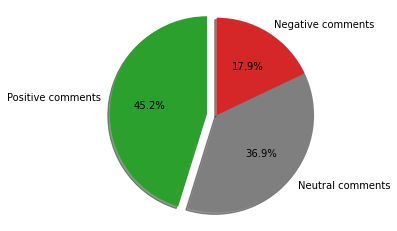

In [37]:
def visualize_sentiment_analysis(analysis_result, labels):
    sizes = [analysis_result["count"]["pos"], analysis_result["count"]["neu"], analysis_result["count"]["neg"]]
    explode = (0.1, 0, 0)
    colors = [mcolors.TABLEAU_COLORS["tab:green"], mcolors.TABLEAU_COLORS["tab:gray"], mcolors.TABLEAU_COLORS["tab:red"]]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors)
    ax1.axis('equal') 
    plt.show()
    
visualize_sentiment_analysis(SA_SOH, ['Positive comments', 'Neutral comments', 'Negative comments'])

_Let's now consider the results obtained with the DataFrame SAC_SOH. In this case, each comment is weighted using its number of likes. 67.4% had a positive feeling about the game, and the number of positive and negative feedbacks decreased in percentage. That means the negative and neutral comments didn't find much approval by the public._

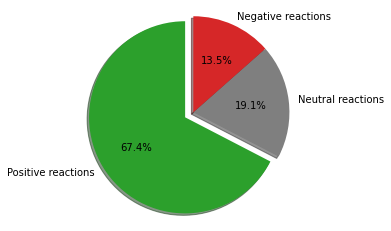

In [38]:
visualize_sentiment_analysis(SAC_SOH, ['Positive reactions', 'Neutral reactions', 'Negative reactions'])

_We have 37%, 19.1% and 17.9%, 13.5% of neutral and negative comments with the two data frames, respectively. Even if most of them are not approved by the majority of the audience, it is still essential to know the reason for their reluctance._

_If we plot the word cloud for the negative and neutral comments, we see some interesting words. Many comments mentioned the word "crossover", which indicates that most negative comments may consider the crossover between Nintendo and Ubisoft characters a weak point of the game. Another interesting word is "Rayman", which refers to the famous Ubisoft character. Fans were expecting to see Rayman in the trailer, but this didn't happen. The "Rayman" word is interesting because it is mentioned in both neutral and negative word clouds. This suggests that adding Rayman to the game could change the mind of neutral but also reluctant players._

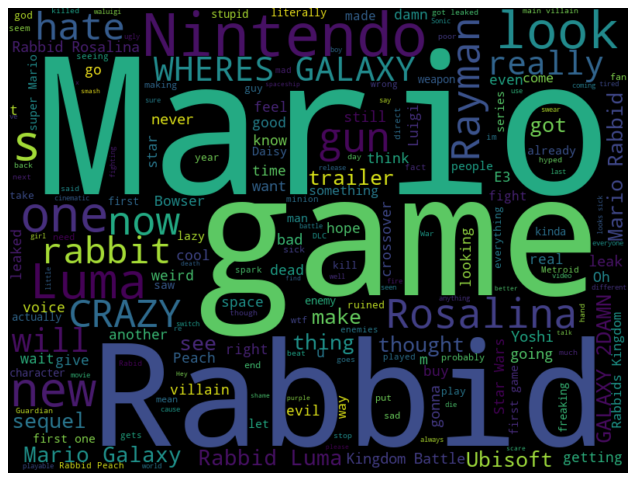

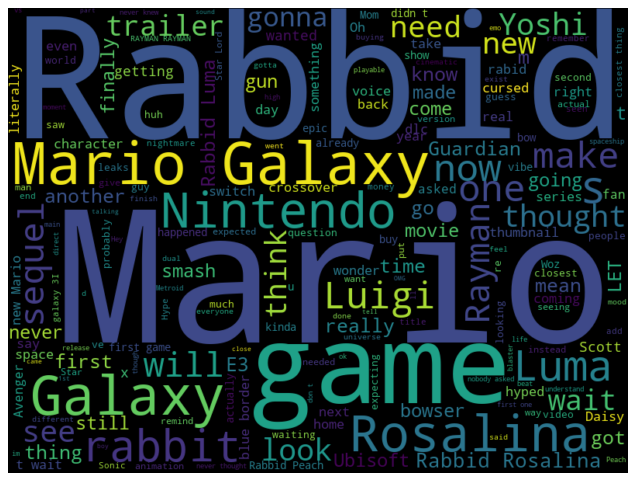

In [39]:
def visualize_word_clouds(comments_dataset, key):
    plt.figure(figsize = (10,10), dpi=80)
    plt.imshow(WordCloud(width=800, height=600).generate(comments_dataset["text"][key]), interpolation='bilinear')
    plt.axis("off")

visualize_word_clouds(SA_SOH, "neg")
visualize_word_clouds(SA_SOH, "neu")

## Objective 2: Analyse the sentiment distribution within the first 24 hours from the announcement of Mario+Rabbids: Sparks of Hope
### Explanation of Results

_The results obtained with the samples stored in SAMPLED_SOH_RES confirm that the sentiment distribution aligns with objective one's results since the first hour after the announcement.<br>
It also shows that throughout the 24 hours, the distribution doesn't change much; it is stable among the time frame.<br>
As we expected, plotting the weighted sentiment variation shows more robust evidence about the successfulness of the announcement. 
It's important to note that we don't have any information about the date and time for a specific like.<br>
This means that in the 24 hours, we are considering likes that could be arrived after.<br>
Given that most of the interactions happened in the first few days after the announcement, this method gives a rough estimate about the appreciation for each comment anyway._

### Visualisation

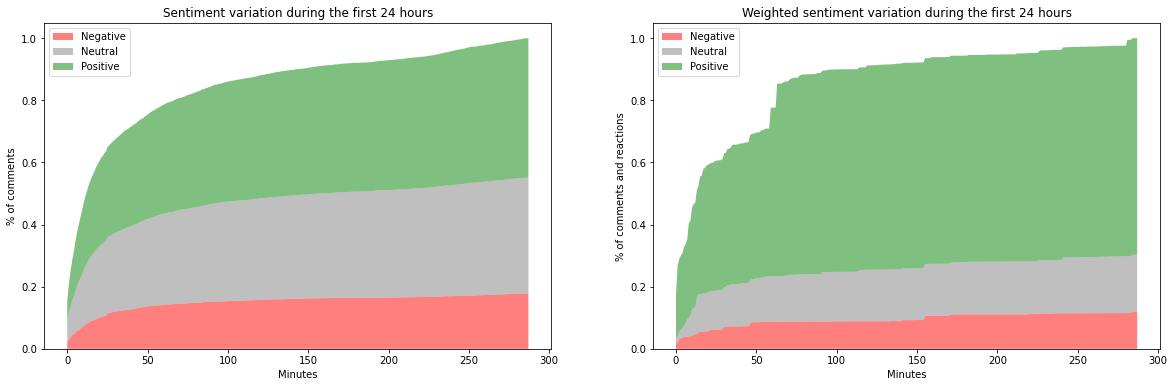

In [40]:
def visualize_sentiment_variation(focus, samples, xlabel, ylabel, title, consider_likes = False):
    sentiment_neg = np.cumsum([comments_sentiment_analysis(sample, consider_likes)["count"]["neg"] for sample in samples])
    sentiment_neu = np.cumsum([comments_sentiment_analysis(sample, consider_likes)["count"]["neu"] for sample in samples])
    sentiment_pos = np.cumsum([comments_sentiment_analysis(sample, consider_likes)["count"]["pos"] for sample in samples])
    
    total_comments = sentiment_neg[-1] + sentiment_neu[-1] + sentiment_pos[-1]
    plt.subplot(1, 2, focus)

    plt.stackplot(
        np.arange(0, len(samples)),
        sentiment_neg / total_comments,
        sentiment_neu / total_comments,
        sentiment_pos / total_comments,
        colors=['red', 'gray', 'green'],
        alpha=0.5,
        labels=["Negative", "Neutral", "Positive"]
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="upper left")

plt.figure(figsize=(20,6))    

visualize_sentiment_variation(1, SAMPLED_SOH_RES, "Minutes", "% of comments", "Sentiment variation during the first 24 hours")
visualize_sentiment_variation(2, SAMPLED_SOH_RES, "Minutes", "% of comments and reactions", "Weighted sentiment variation during the first 24 hours", True)

plt.show()

## Objective 3
### Explanation of Results

_Analysing the "Mario+Rabbids: Kingdom Battle" announcement, we see some similarities with its sequel.<br>
Interestingly, even if, at that time, fans didn't know exactly what to expect from the idea of a crossover Ubisoft-Nintendo, in both cases, the sentiment distribution is almost identical to the one seen in objective one.<br>
Looking at the sentiment variation, we notice that the positive sentiment converged slower than its sequel in the left graph. This means that the RKB announcement trailer received a lower number of comments per minute.<br> This can be partially explained by the fact that the franchise didn't exist, so there wasn't a strong community waiting for it._

### Visualisation

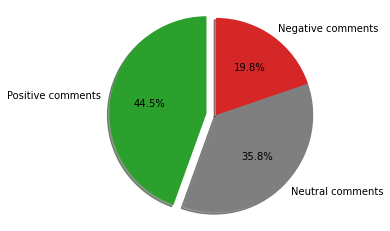

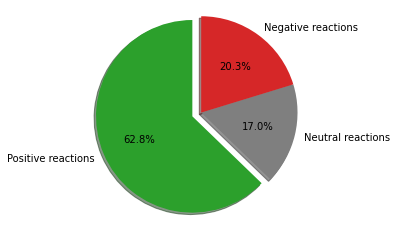

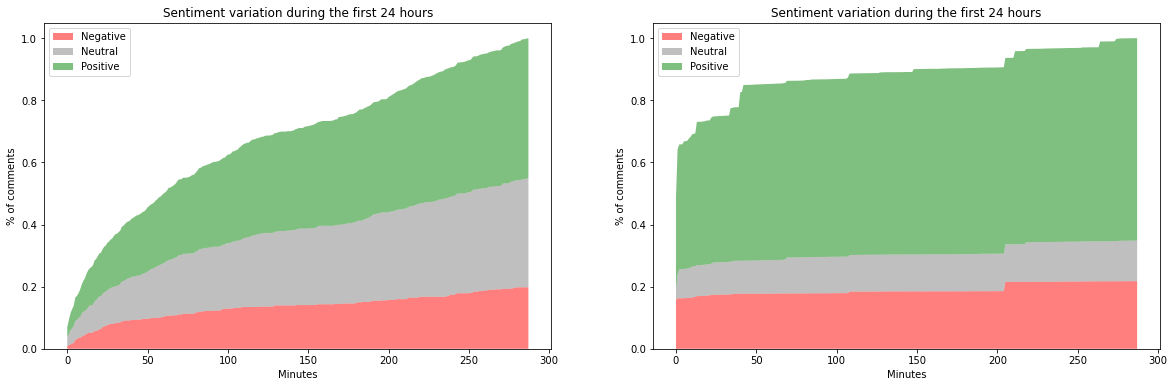

In [41]:
visualize_sentiment_analysis(SA_RKB, ['Positive comments', 'Neutral comments', 'Negative comments'])
visualize_sentiment_analysis(SAC_RKB, ['Positive reactions', 'Neutral reactions', 'Negative reactions'])

plt.figure(figsize=(20,6))    

visualize_sentiment_variation(1, SAMPLED_RKB_RES, "Minutes", "% of comments", "Sentiment variation during the first 24 hours")
visualize_sentiment_variation(2, SAMPLED_RKB_RES, "Minutes", "% of comments", "Sentiment variation during the first 24 hours", True)

plt.show()

# Conclusion (5 marks)

### Acheivements
_The results show that Mario+Rabbids: Sparks of Hope's announcement trailer is a success in terms of appreciation. The comparison with its predecessor revealed greater attention by the public in the first 24 hours and showed that the sentiment distribution obtained aligns with the previous results. This confirms that the announcement is a success, but still, there are some improvements Ubisoft can make to satisfy a larger portion of the audience._

### Limitations

_Unfortunately, the analysis has multiple limitations. Firstly, the youtube API doesn't grant access to all the relevant information about a video. For example, having the exact publication time could have given more precise results when plotting the data. Another interesting information is the time at which a like is added to a comment. This could have been useful to select only the likes added in the first 24 hours from the announcement. Nonetheless, huge limitations are imposed by the sentiment analyser. Even if vaderSentiment\[3\] is much more precise than most sentiment analysers available for Python, many sentences are still challenging to evaluate correctly. For example, "this game is sick!" would be assessed as a negative sentence while in this context should be considered positive. A way better sentiment analysis can be carried out using SentiStrenght\[4\]. Unfortunately, the fact that SentiStrenght\[4\] is only available on windows and requires java to work properly makes it inconvenient for a cross-platform notebook environment._

### Future Work

_In future works, we would like to strengthen our pipeline using SentiStrenght\[4\] to achieve a higher fidelity of the sentiment analyser. Introducing a web scraper could give us new relevant information about a video, such as the number of dislikes for each comment, thus enhancing the dataset and the possible outcome. In conclusion, there is still some room for improvements in performance and precision for what concerns the English filtering. We hypothesise that by using Google Translate, we could get much better results._

# Bibliography

1. WordNet. Princeton University. Princeton University "About WordNet." WordNet. 2010.
2. FastText. Joulin, Armand and Grave, Edouard and Bojanowski, Piotr and Mikolov, Tomas. Bag of Tricks for Efficient Text Classification. arXiv preprint arXiv:1607.01759. 2016.
3. VaderSentiment. Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014
4. SentiStrength. University of Wolverhampton. [Project Website](http://sentistrength.wlv.ac.uk/#About)
